## 1d toy problem
objectives:
    1. train gp regression model using gpflow for the gaussian kernel
    2. obtain access to hyperparameters
    
underlying function $f$
$$ f(x) = (6x-2)^2 \sin(12x-4)$$
subject to $x\in [0,1] \subset \mathbb{R}$

In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
from f import *

construct and plot the dataset $\mathcal{D}^{1:t}=\{ x^{1:t}, y^{1:t} \}$ using the function of interest 

here $t$ is 8

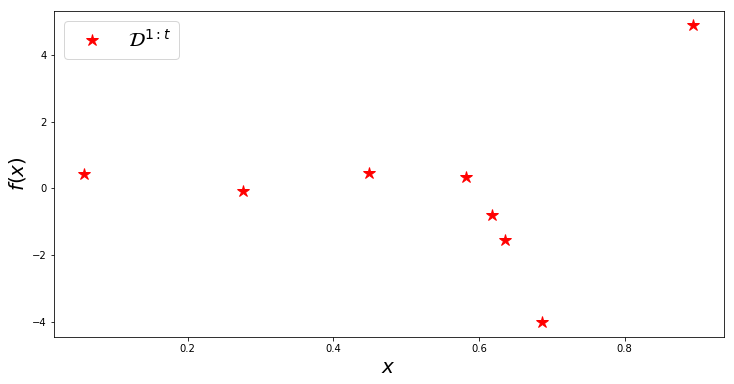

In [2]:
t = 8
X = np.reshape(np.random.rand(t,1),(-1,1))
Y = np.reshape(f(X), (-1,1))
plt.plot(X,Y,'*', color='red', markersize=12, label='$\mathcal{D}^{1:t}$')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$f(x)$', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model Construction
1. define the kernel
2. fix the likelyhood variance $\epsilon$
$$y^{1:t}=f^{1:t}+\epsilon$$

where $\epsilon\sim\mathcal{N}(0,\nu)$ denotes measurement noise (i.e. the likelyhood variance in the gpflow notation)

In [3]:
k = gpflow.kernels.RBF(1, ARD=True)
meanf = gpflow.mean_functions.Zero()
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01
m.kern.variance.trainable = True
m.likelihood.variance.trainable = False
print(m.read_trainables())

{'GPR/kern/variance': array(1.0), 'GPR/kern/lengthscales': array([ 1.])}


plot the gp before optimizing the hyerparameters and show the hyperparameters

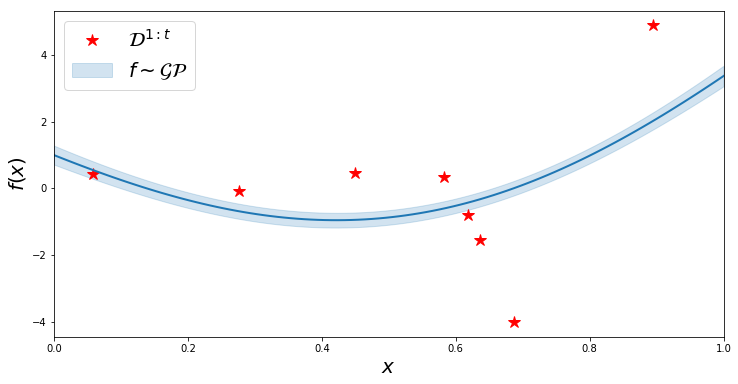

                             class prior transform  trainable shape  \
GPR/likelihood/variance  Parameter  None       +ve      False    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True  (1,)   
GPR/kern/variance        Parameter  None       +ve       True    ()   

                         fixed_shape  value  
GPR/likelihood/variance         True   0.01  
GPR/kern/lengthscales           True  [1.0]  
GPR/kern/variance               True    1.0  


In [4]:
def plot(m):
    xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, '*', markersize=12, color='red', label='$\mathcal{D}^{1:t}$')
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2, label='$f\sim\mathcal{GP}$')
    plt.xlim(0.0, 1.0)
    plt.xlabel('$x$', fontsize=20)
    plt.ylabel('$f(x)$', fontsize=20)
    plt.legend(fontsize=20, loc=2)
    plt.show()

plot(m)
print(m)

optimize the hyperparameters and replot the posterior gp

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 14.775713
  Number of iterations: 15
  Number of functions evaluations: 23


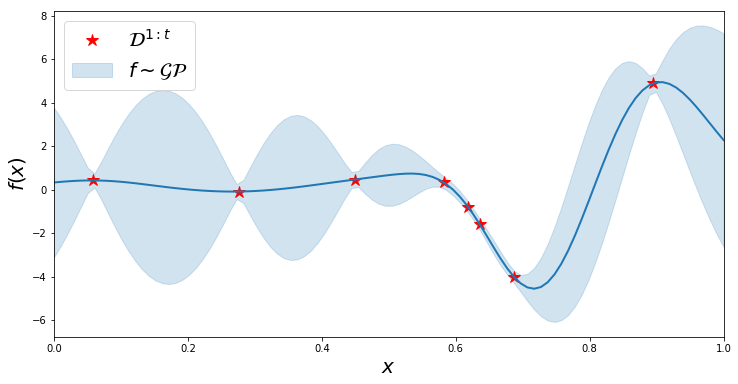

                             class prior transform  trainable shape  \
GPR/likelihood/variance  Parameter  None       +ve      False    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True  (1,)   
GPR/kern/variance        Parameter  None       +ve       True    ()   

                         fixed_shape              value  
GPR/likelihood/variance         True               0.01  
GPR/kern/lengthscales           True  [0.0818438755416]  
GPR/kern/variance               True  7.416898457527022  


In [5]:
gpflow.train.ScipyOptimizer().minimize(m)
m.compile()
plot(m)
print(m)

Extract the hyperparameters from the model

In [6]:
print('variance    :', m.kern.variance.value)
print('lengthscales:', m.kern.lengthscales.value)

variance    : 7.416898457527022
lengthscales: [ 0.08184388]


## Using Markov Chain Monte Carlo (MCMC) for hyperparameter estimation

We are now going to use MCMC to obtain posterior distributions over the hyperparameters in the GP regression model. 
To do this we will need to
    1. set priors on the kernel parameters
    2. run MCMC and see how much posterior uncertainty are in the hyperparameters
    
Below we perfrom step 1 by setting a Gaussian prior $p(\theta)\sim\mathcal{N}(\theta_{MLE},\theta_{MLE}^2)$, thus we use the values from MLE (above) as the prior over the hyperparameters with a Gaussian density.

In [7]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gaussian(m.kern.lengthscales.value, m.kern.lengthscales.value**2.0)
m.kern.variance.prior = gpflow.priors.Gaussian(m.kern.variance.value, m.kern.variance.value**2.0)
m.compile()
print(m)

                             class                            prior transform  \
GPR/likelihood/variance  Parameter                             None       +ve   
GPR/kern/lengthscales    Parameter   N([ 0.08184388],[ 0.00669842])       +ve   
GPR/kern/variance        Parameter  N([ 7.41689846],[ 55.01038273])       +ve   

                         trainable shape  fixed_shape              value  
GPR/likelihood/variance      False    ()         True               0.01  
GPR/kern/lengthscales         True  (1,)         True  [0.0818438755416]  
GPR/kern/variance             True    ()         True  7.416898457527022  


We then use Hamiltonian Monte Carlo to obtain the values of the hyperparameters, that is 
$$ \theta_{HMC} = 
\dfrac{1}{N}\sum_{i=1}^N \theta_i 
\approx
\dfrac{1}{N}\sum_{i=1}^N \mathcal{N}(\theta_{MLE}, \theta_{MLE}^2)
$$

NOTE: right now this is wrong since I am making to many assumptions on $p(\theta)$...
I need to be able to use a simple prior and retrieve the posterior, that is
$$ p(\theta|\mathcal{D}^{1:t}) = \dfrac{p(\mathcal{D}^{1:t}|\theta)p(\theta)}{p(\mathcal{D}^{1:t})}$$
So my question becomes: are we assuming the prior and using that as the posterior or will we obtain the posterior with the equation above where we also estimate $p(\mathcal{D}^{1:t}|\theta)$?

In the following steps we train the hyperparameters using HMC (Hamiltonian Monte Carlo)

In [8]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=5000, epsilon=0.05, lmin=10, lmax=20, logprobs=False)

We can plot the $i$th hyperparameter $\theta_i$ using a sampling procedure as shown in the figure below.

Text(0,0.5,'parameter value')

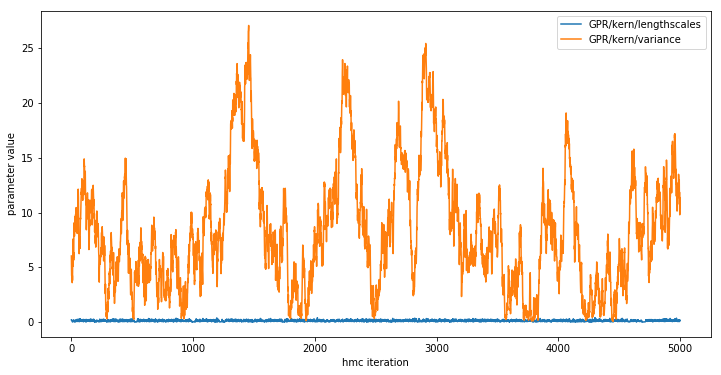

In [9]:
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

Using the new hyperparameters from HMC we can plot the GP once again and see that the error bars seem to be "more reasonable"

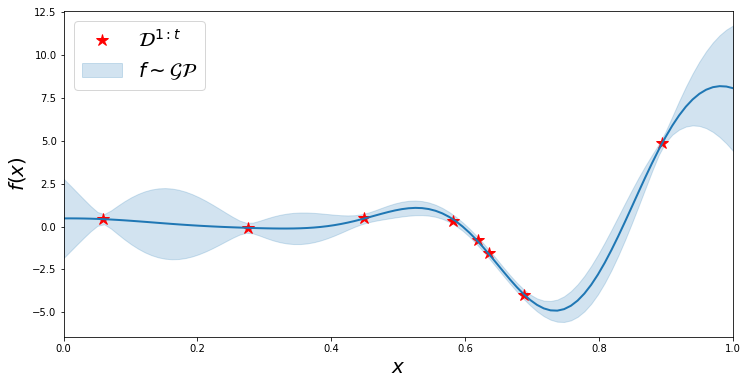

                             class                            prior transform  \
GPR/likelihood/variance  Parameter                             None       +ve   
GPR/kern/lengthscales    Parameter   N([ 0.08184388],[ 0.00669842])       +ve   
GPR/kern/variance        Parameter  N([ 7.41689846],[ 55.01038273])       +ve   

                         trainable shape  fixed_shape               value  
GPR/likelihood/variance      False    ()         True                0.01  
GPR/kern/lengthscales         True  (1,)         True    [0.142208382936]  
GPR/kern/variance             True    ()         True  10.476370563343783  


In [11]:
plot(m)
print(m)

Here we plot the hyperparameters (kernel variance versus kernel likelihood)

Text(0,0.5,'signal_variance')

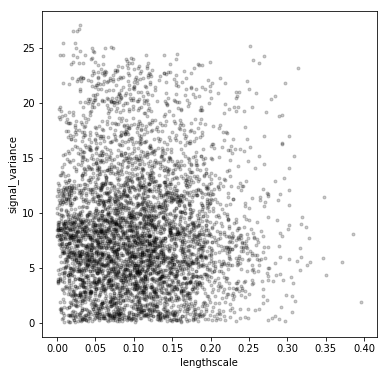

In [14]:
plt.figure(figsize=(6,6))
plt.plot(samples['GPR/kern/lengthscales'], samples['GPR/kern/variance'], 'k.', alpha=0.2)
plt.xlabel('lengthscale')
plt.ylabel('signal_variance')

We can sample from the hyperparameters and plot the posterior predictions by iterating through the samples. and draw samples from the prediction function

(0, 1)

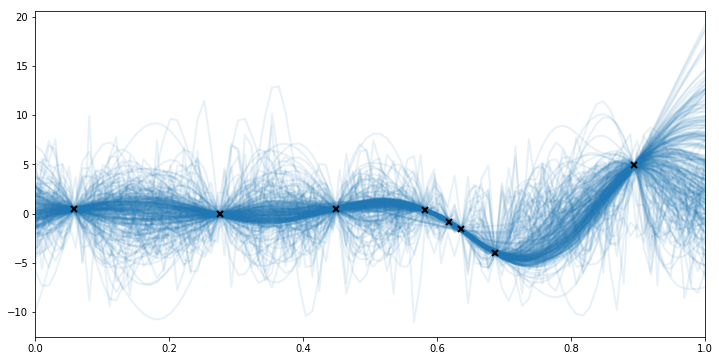

In [15]:
#plot the function posterior
xx = np.linspace(0., 1., 100)[:,None]
plt.figure()
for i, s in samples.iloc[::20].iterrows():
    m.assign(s)
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)

plt.plot(X, Y, 'kx', mew=2)
plt.xlim(0, 1)